In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Load the combined CSV file
df = pd.read_csv('data/combined_kiosk_locations.csv')

# Display the first few rows of the dataframe to understand its structure
df.head()


,lat,lon,type,company,name
0,40.446374069275095,49.70095361852881,competitor,abb,İdeal market (Hökməli)
1,40.4467429,49.7746598,competitor,abb,Respublika DYP
2,40.44131784918866,49.74818651483471,competitor,abb,Bazarstore (Höküməli)
3,40.523947,49.687323,competitor,abb,Araz market (Saray)
4,40.511532,49.941772,competitor,abb,Araz Market (Məhəmmədi)


In [18]:
# Analyze the distribution of locations by type
location_distribution = df['type'].value_counts()

# Display the distribution
location_distribution


type
competitor    3382
company       1133
potential      608
Name: count, dtype: int64

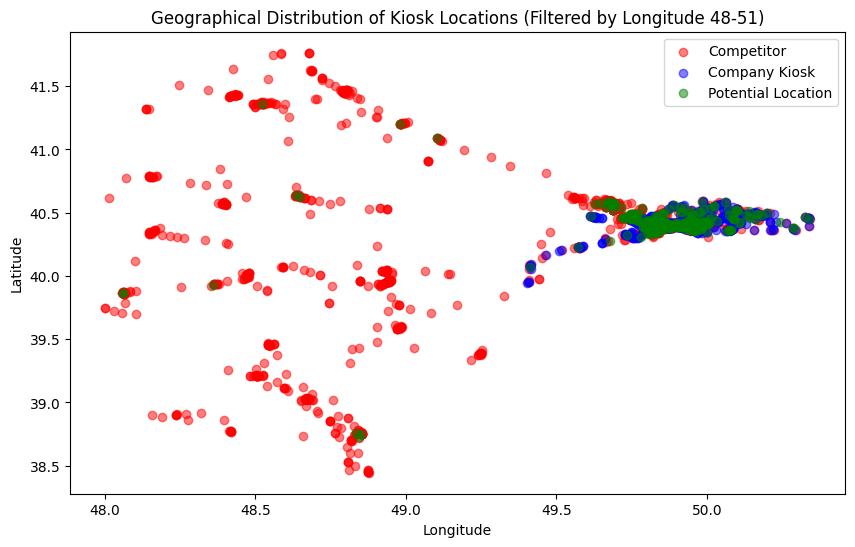

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the latitude and longitude data are in numeric format
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df['lon'] = pd.to_numeric(df['lon'], errors='coerce')

# Filter the dataframe for coordinates between 48 and 51 degrees longitude
filtered_df = df[(df['lon'] >= 48) & (df['lon'] <= 51)]

plt.figure(figsize=(10, 6))

# Plot each type with different colors within the filtered range
plt.scatter(filtered_df[filtered_df['type'] == 'competitor']['lon'], filtered_df[filtered_df['type'] == 'competitor']['lat'], color='red', label='Competitor', alpha=0.5)
plt.scatter(filtered_df[filtered_df['type'] == 'company']['lon'], filtered_df[filtered_df['type'] == 'company']['lat'], color='blue', label='Company Kiosk', alpha=0.5)
plt.scatter(filtered_df[filtered_df['type'] == 'potential']['lon'], filtered_df[filtered_df['type'] == 'potential']['lat'], color='green', label='Potential Location', alpha=0.5)

# Add title and legend
plt.title('Geographical Distribution of Kiosk Locations (Filtered by Longitude 48-51)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.show()



In [30]:
import pandas as pd
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Load the combined CSV file
filtered_df = pd.read_csv('data/combined_kiosk_locations.csv')

# Ensure that the latitude and longitude data are in numeric format
filtered_df['lat'] = pd.to_numeric(filtered_df['lat'], errors='coerce')
filtered_df['lon'] = pd.to_numeric(filtered_df['lon'], errors='coerce')

# Drop rows with invalid lat/lon values
filtered_df = filtered_df.dropna(subset=['lat', 'lon'])

# Extract latitude and longitude for competitors and company kiosks
competitor_coords = filtered_df[filtered_df['type'] == 'competitor'][['lat', 'lon']].values
company_coords = filtered_df[filtered_df['type'] == 'company'][['lat', 'lon']].values

# Build KD-Trees for fast nearest-neighbor lookup
competitor_tree = cKDTree(competitor_coords)
company_tree = cKDTree(company_coords)

# List to store final scores
final_scores = []

# Iterate through each potential location
for index, row in filtered_df[filtered_df['type'] == 'potential'].iterrows():
    potential_loc = [row['lat'], row['lon']]
    
    # Find the nearest competitor and company kiosk
    _, nearest_competitor_dist = competitor_tree.query(potential_loc)
    _, nearest_company_dist = company_tree.query(potential_loc)
    
    # Calculate scores based on distances
    score_competitor = nearest_competitor_dist  # further is better
    score_company = 1 / nearest_company_dist if nearest_company_dist > 0 else 0  # closer is better
    
    # Calculate weighted score
    weighted_score = (score_competitor * 0.6) + (score_company * 0.4)
    
    # Append the score with the location data
    final_scores.append((row['lat'], row['lon'], row['name'], row['company'], weighted_score))

# Convert the final scores into a DataFrame for easy viewing
scores_df_optimized = pd.DataFrame(final_scores, columns=['Latitude', 'Longitude', 'Location Name', 'Company', 'Weighted Score']).sort_values(by='Weighted Score', ascending=False)

# Select the top 3 results (highest scores)
top_3 = scores_df_optimized.head(3)
top_3



,Latitude,Longitude,Location Name,Company,Weighted Score
222,39.636955,46.546642,Araz Supermarket Laçın,araz,2022.600978
155,40.460838,49.741203,Araz Xirdalan-5 Supermarket,araz,2022.011429
129,40.459122,49.744308,Araz Xırdalan-4 Supermarket,araz,2022.011429
